# Generate tables and figures for paper

In [1]:
import pickle
from pathlib import Path

import nibabel as nib
import pandas as pd

from livingpark_utils.zeighamietal.constants import (
    COL_AGE,
    COL_PAT_ID, 
    COL_SEX,
    COL_FOLLOWUP,
    COL_STATUS, 
    COL_UPDRS2,
    COL_UPDRS3,
    COL_ADL,
    COL_UPDRS1,
    COL_MOCA,
    COL_PIGD,
    COL_GCO,
    STATUS_HC,
    STATUS_PD,
)

In [2]:
experiment_map = {
    1: '4554467823934740347_nlr4_dbm8_from_nifti_old_pipeline_qc',
    2: '4554467823934740347_nlr4_dbm8_from_nifti_old_pipeline_qc-30',
    3: '_460520092359662532_from_nifti_old_pipeline_qc',
    4: '_460520092359662532_from_nifti_old_pipeline_qc-30',
    5: '_460520092359662532_old_pipeline_qc',
    6: '_460520092359662532_old_pipeline_qc-30',
    7: '_460520092359662532_from_nifti_qc',
    8: '_460520092359662532_from_nifti_qc-30',
    9: '_460520092359662532_qc',
    10: '_460520092359662532_qc-30',
    # 11: '6874312680158848047_qc-30',
    11: '1764925582561745833_qc-30',
}

## Demographics tables and ICA plots for each experiment

### Load results

In [4]:
experiment = 11
long_tag = experiment_map[experiment]

dpath_outputs = Path("..", "outputs")
fpath_results = dpath_outputs / f'results-{long_tag}.pkl'

with fpath_results.open('rb') as file_results:
    results = pickle.load(file_results)

# print(f'auc:\t\t{results["auc"]}')
# print(f'auc_p_value:\t{results["auc_p_value"]}')
print(f'ica_corr:\t{results["ica_corr"]}')

# fill_width = max(len(key) for key in results.keys())
# for key, value in results.items():
#     if isinstance(value, nib.nifti1.Nifti1Image):
#         value = f'<Nifti1Image{value.shape}>'
#     elif isinstance(value, pd.DataFrame):
#         value = f'<pd.DataFrame{value.shape}>'
#     elif 'subjects' in key:
#         value = f'<{len(value)} subjects>'
#     print(f'{key.ljust(fill_width)}\t\t{value}')

ica_corr:	0.7133418546719942


### Pre-DBM demographics table (PD and HC)

In [5]:
df_assessments = pd.read_csv(results['fpath_assessments'])
# df_assessments.describe()

In [44]:
# print(df_assessments[COL_FOLLOWUP].value_counts(dropna=False))
# for is_followup in df_assessments[COL_FOLLOWUP].drop_duplicates():
#     print(f'===== is_followup: {is_followup} =====')
#     print(
#         df_assessments.loc[
#             df_assessments[COL_FOLLOWUP] == is_followup, 
#             COL_STATUS,
#         ].value_counts(dropna=False)
#     )

In [6]:
def to_1_decimal_str(f):
    return str(round(f, 1))

col_male = "is_male"
col_cohort = "cohort"
col_age_diag = "age_diag"
COL_FOLLOWUP = 'is_followup'

# only use baseline 
df_assessments_baseline = df_assessments.loc[~df_assessments[COL_FOLLOWUP]]

# append
dfs_summary = []
for status in [STATUS_PD, STATUS_HC]:
    df_summary = df_assessments_baseline.loc[df_assessments_baseline[COL_STATUS] == status]
    df_summary = df_summary.drop(columns=[COL_PAT_ID, COL_SEX])
    df_summary[col_cohort] = f"{status} (n = {len(df_summary)})"
    dfs_summary.append(df_summary)

df_summary = pd.concat(dfs_summary)
df_summary_means = (
    df_summary.groupby([col_cohort]).mean(numeric_only=True).applymap(to_1_decimal_str)
)
df_summary_stds = (
    df_summary.groupby([col_cohort]).std(numeric_only=True).applymap(to_1_decimal_str)
)
df_summary_stds = " (" + df_summary_stds + ")"
df_summary_stds.loc[:, col_male] = ""
df_summary_combined = (df_summary_means + df_summary_stds).T
df_summary_combined = df_summary_combined.applymap(lambda x: "-" if "nan" in x else x)
df_summary_combined = df_summary_combined.loc[[COL_AGE, col_male, COL_MOCA]]
df_summary_combined = df_summary_combined.rename(
    index={
        col_male: "Male (%)",
        COL_MOCA: "MoCA",
        COL_AGE: "Age",
    }
)

print(long_tag)
df_summary_combined

1764925582561745833_qc-30


cohort,Healthy Control (n = 117),Parkinson's Disease (n = 232)
Age,59.7 (11.3),61.3 (9.1)
Male (%),66.7,64.2
MoCA,28.3 (1.2),27.3 (2.2)


### Classification demographics table (PD only)

In [7]:
results['df_assessments_classification'][COL_FOLLOWUP].value_counts(dropna=False)

False    222
True     222
Name: is_followup, dtype: int64

In [14]:
def to_1_decimal_str(f):
    return str(round(f, 1))

# append
dfs_summary = []
df_assessments_classification: pd.DataFrame = results['df_assessments_classification']
for is_followup in df_assessments_classification[COL_FOLLOWUP].drop_duplicates():
    df_summary = df_assessments_classification.loc[df_assessments_classification[COL_FOLLOWUP] == is_followup]
    df_summary.loc[:, col_cohort] = f"PD patients (n = {len(df_assessments_classification.drop_duplicates(COL_PAT_ID))})"
    dfs_summary.append(df_summary)

df_summary = pd.concat(dfs_summary)
print(df_summary.columns)
df_summary = df_summary.drop(columns=[COL_PAT_ID, COL_AGE, COL_PIGD, 'INFODT', 'EVENT_ID', 'COHORT_DEFINITION', 'BIRTHDT', 'PDDXDT'])
df_summary_means = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).mean(numeric_only=False).applymap(to_1_decimal_str)
)
df_summary_stds = (
    df_summary.groupby([col_cohort, COL_FOLLOWUP]).std(numeric_only=False).applymap(to_1_decimal_str)
)
df_summary_stds = " (" + df_summary_stds + ")"
df_summary_stds.loc[:, col_male] = ""
df_summary_combined = (df_summary_means + df_summary_stds).T
df_summary_combined = df_summary_combined.loc[
    [col_age_diag, col_male, COL_UPDRS2, COL_UPDRS3, COL_ADL, COL_UPDRS1, COL_MOCA, COL_GCO]
]
# df_summary_combined = df_summary_combined.applymap(lambda x: "-" if "nan" in x else x)
df_summary_combined = df_summary_combined.rename(
    index={
        col_age_diag: "Age at diagnosis",
        col_male: "Male (%)",
        COL_UPDRS2: "UPDRS Part II",
        COL_UPDRS3: "UPDRS Part III",
        COL_ADL: "S&E ADL",
        # COL_PIGD: "PIGD",
        COL_UPDRS1: "UPDRS Part I",
        COL_MOCA: "MoCA",
        COL_GCO: "Global composite outcome",
    }
)
df_summary_combined

Index(['PATNO', 'INFODT', 'EVENT_ID', 'NP2PTOT', 'NP3TOT', 'MSEADLG', 'PIGD',
       'NP1RTOT+NP1PTOT', 'MCATOT', 'is_followup', 'AGE_AT_VISIT',
       'COHORT_DEFINITION', 'SEX', 'BIRTHDT', 'PDDXDT', 'age_diag', 'is_male',
       'GCO', 'cohort'],
      dtype='object')


/tmp/ipykernel_46414/817714437.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary.loc[:, col_cohort] = f"PD patients (n = {len(df_assessments_classification.drop_duplicates(COL_PAT_ID))})"
/tmp/ipykernel_46414/817714437.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary.loc[:, col_cohort] = f"PD patients (n = {len(df_assessments_classification.drop_duplicates(COL_PAT_ID))})"


cohort                   PD patients (n = 222)             
is_followup                              False        True 
Age at diagnosis                    60.6 (9.1)   60.6 (9.1)
Male (%)                                  64.4         64.4
UPDRS Part II                        5.7 (4.0)   10.8 (7.3)
UPDRS Part III                      21.8 (9.1)  23.1 (12.0)
S&E ADL                             93.6 (5.7)  86.1 (11.9)
UPDRS Part I                         5.4 (3.9)    9.6 (6.2)
MoCA                                27.3 (2.2)   26.5 (3.3)
Global composite outcome             0.0 (0.4)    0.2 (0.6)

### ICA plots

display_mode: z
cut_coords: [-28, -10, 4, 16, 32, 65, 68]
14 6
Min: -3.753	Max: 24.396
Min: -6.030	Max: 11.644
14 10
Min: -4.478	Max: 7.638
Min: -4.241	Max: 6.945
Min: -5.879	Max: 11.900
Min: -5.987	Max: 12.203
14 10
Min: -4.940	Max: 7.411
Min: -4.285	Max: 7.185
Min: -5.034	Max: 8.174
Min: -4.838	Max: 7.741
14 4
Min: -6.105	Max: 11.412


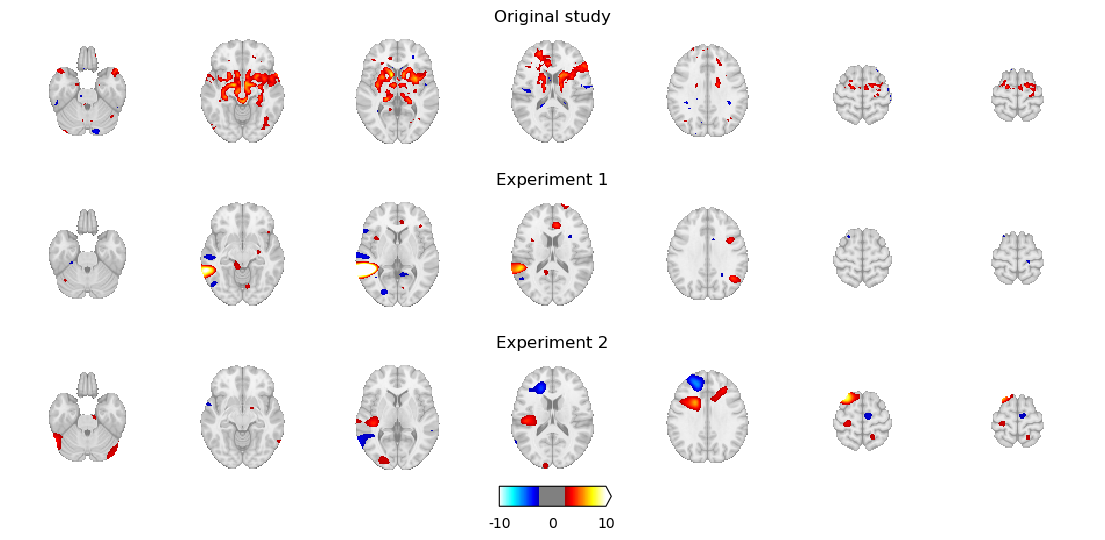

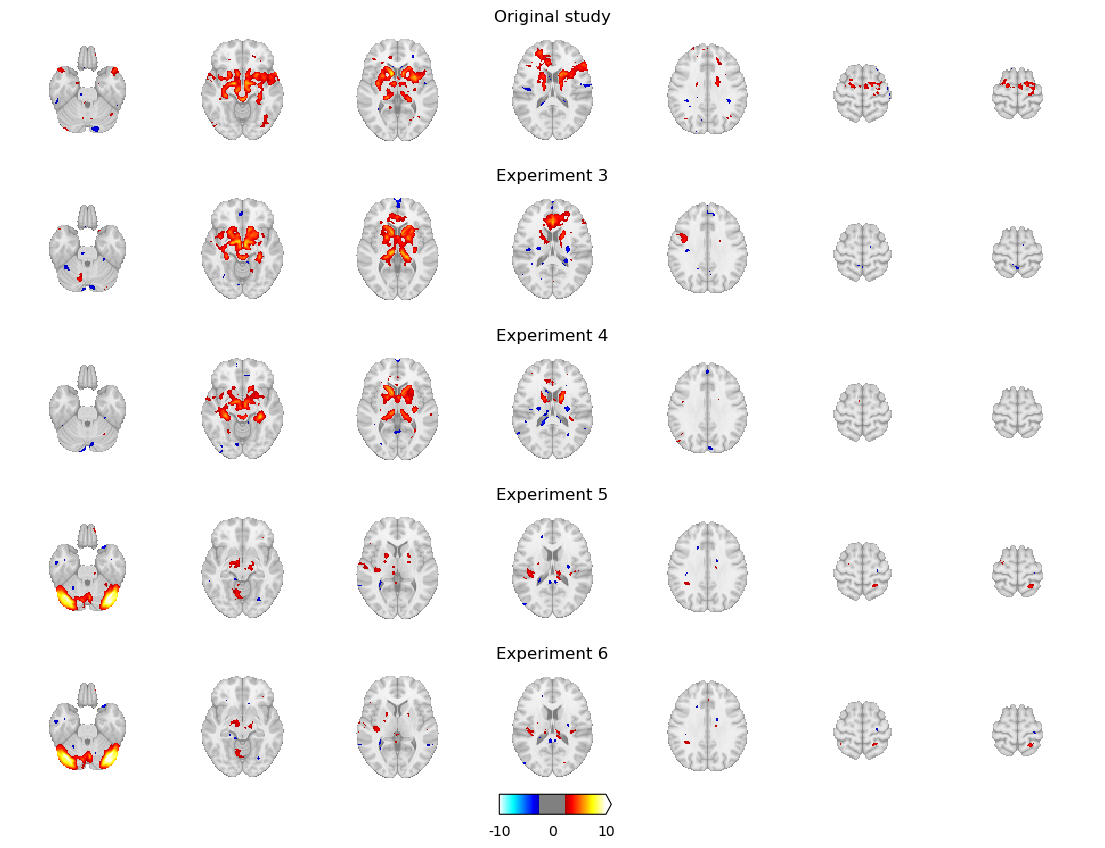

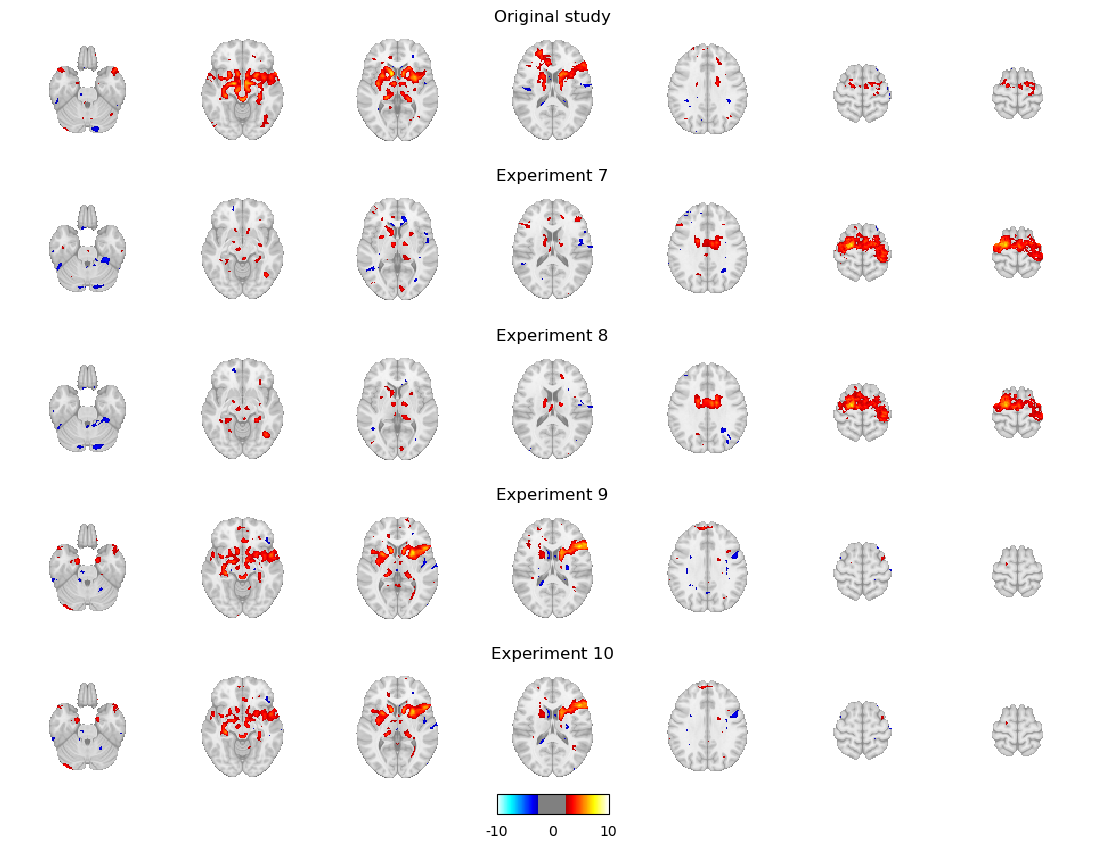

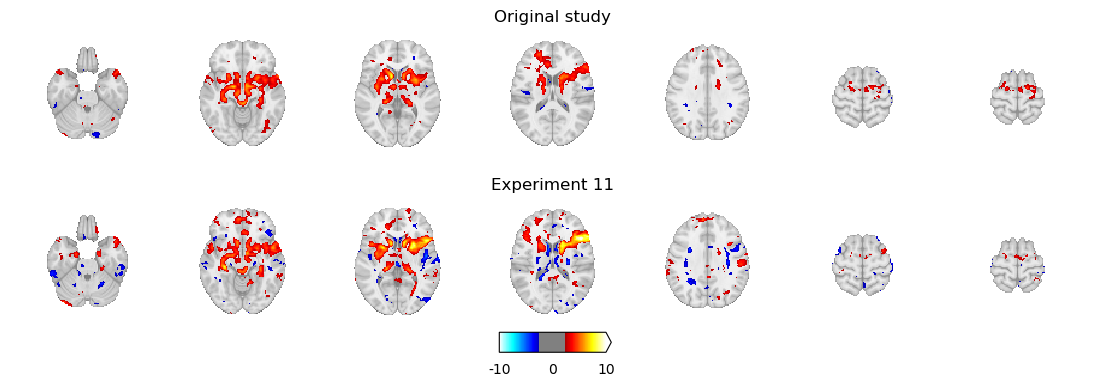

In [32]:
import pickle
from pathlib import Path

import matplotlib.colors
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn.plotting
import numpy as np
from matplotlib import colormaps
from matplotlib.colorbar import ColorbarBase

threshold = 2.5
annotate = False
pad = 0
vmax = 10
colorbar = False
display_mode = 'z'
cut_coords = [-28, -10, 4, 16, 32, 65, 68]
ax_width = 14
ax_height = 2

cmap = colormaps['cold_hot']
cmap.colorbar_extend = True
nb_ticks = 3
brain_color=(0.5, 0.5, 0.5)
cmap = 'cold_hot'
cbar_width_frac = 0.08 # relative to fig
cbar_height_frac = 0.1 # relative to ax

fpath_ori = '../melodic_IC_0007.nii.gz'
img_ori = nib.load(fpath_ori)

dpath_outputs = Path("..", "outputs")

experiment_lists = [
    [1, 2], 
    [3, 4, 5, 6],
    [7, 8, 9, 10],
    [11]
]

cbar_vmin = -vmax
cbar_vmax = vmax
our_cmap = colormaps[cmap]
cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
norm = matplotlib.colors.Normalize(vmin=cbar_vmin, vmax=cbar_vmax, clip=True)
ticks = np.linspace(cbar_vmin, cbar_vmax, nb_ticks)
bounds = np.linspace(cbar_vmin, cbar_vmax, our_cmap.N)
transparent_start = int(norm(-threshold, clip=True) * (our_cmap.N - 1))
transparent_stop = int(norm(threshold, clip=True) * (our_cmap.N - 1))
for i in range(transparent_start, transparent_stop):
    cmaplist[i] = brain_color + (0.,)  # transparent
our_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, our_cmap.N
)

def plot_ax(img, ax=None, title=None):
    # ax.set_yticks([])
    display = nilearn.plotting.plot_stat_map(
        img, threshold=threshold, display_mode=display_mode, 
        cut_coords=cut_coords, colorbar=colorbar, vmax=vmax, annotate=annotate, cmap=cmap,
        axes=ax,
    )
    display.axes[cut_coords[len(cut_coords) // 2]].ax.set_title(title, pad=pad)
    # ax.axis('on')
    # ax.remove()
    return display

print(f'display_mode: {display_mode}')
print(f'cut_coords: {cut_coords}')

figs = []
for experiment_list in experiment_lists:
    n_rows = len(experiment_list) + 1
    n_cols = 1
    fig_width = ax_width * n_cols
    fig_height = ax_height * n_rows
    print(fig_width, fig_height)
    fig, axes_corrs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(fig_width,fig_height))

    ax_ori = axes_corrs[0]
    axes_rep = axes_corrs[1:]

    # fig.subplots_adjust(right=0.5)

    # # plot original ICs
    # # ax_ori.set_title('Original study', pad=pad)
    # display = nilearn.plotting.plot_stat_map(
    #     img_ori, threshold=threshold, display_mode=display_mode, 
    #     cut_coords=cut_coords, colorbar=colorbar, vmax=vmax, annotate=annotate, cmap=cmap,
    #     axes=ax_ori,
    # )
    # display.axes[cut_coords[len(cut_coords) // 2]].ax.set_title('Original study', pad=pad)
    # # display.axes[cut_coords[len(cut_coords) // 2]].ax.axis('on')
    plot_ax(img_ori, ax_ori, title='Original study')

    extend_cbar_max = False
    extend_cbar_min = False

    for experiment, ax in zip(experiment_list, axes_rep):
        long_tag = experiment_map[experiment]
        fpath_results = dpath_outputs / f'results-{long_tag}.pkl'

        with fpath_results.open('rb') as file_results:
            results = pickle.load(file_results)

        img_component = results["img_component"]

        data = img_component.get_fdata()
        data_min = data.min()
        data_max = data.max()
        extend_cbar_min = extend_cbar_min or (data_min < cbar_vmin)
        extend_cbar_max = extend_cbar_max or (data_max > cbar_vmax)
        print(f'Min: {data_min:.3f}\tMax: {data_max:.3f}')

        # # ax.set_ylabel(f'Experiment {experiment}')
        # display = nilearn.plotting.plot_stat_map(
        #     img_component, threshold=threshold, display_mode=display_mode, 
        #     cut_coords=cut_coords, axes=ax, vmax=vmax, cmap=cmap,
        #     annotate=annotate, colorbar=colorbar,
        # )
        # display.axes[cut_coords[len(cut_coords) // 2]].ax.set_title(f'Experiment {experiment}')
        # # ax.set_title(f'Experiment {experiment}', pad=pad)
        display = plot_ax(img_component, ax, title=f'Experiment {experiment}')
        # break

    # fig.subplots_adjust(left=0.1)

    if extend_cbar_max and extend_cbar_min:
        extend = 'both'
    elif extend_cbar_min:
        extend = 'min'
    elif extend_cbar_max:
        extend = 'max'
    else:
        extend = 'neither'
    our_cmap.colorbar_extend = extend

    if extend == 'max':
        adjust = 0.95
    elif extend == 'min':
        adjust = 1.05
    else:
        adjust = 1

    middle_ax_x0, middle_ax_y0, middle_ax_width, _ = display.axes[cut_coords[len(cut_coords) // 2]].ax.get_position().bounds
    middle_xmid = middle_ax_x0 + middle_ax_width/2

    ax_cbar = fig.add_axes(rect=[
        middle_xmid-cbar_width_frac*adjust/2,             # left
        # (cbar_height_frac*ax_height + 0.05)/fig_height, # bottom
        middle_ax_y0-(cbar_height_frac*ax_height)/fig_height, # bottom
        cbar_width_frac,             # width
        (cbar_height_frac*ax_height)/fig_height,        # height
    ])
    cbar_test = ColorbarBase(
        ax_cbar, 
        ticks=ticks, 
        norm=norm, 
        cmap=our_cmap, 
        orientation='horizontal', 
        boundaries=bounds, 
        spacing='proportional',
        format='%.2g',
    )
    ax_cbar.set_facecolor(brain_color)
    # ax_cbar.yaxis.tick_left()
    ax_cbar.xaxis.set_tick_params(width=0)

    figs.append(fig)

    # break

# fig.tight_layout()

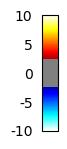

In [50]:
import matplotlib.colors
import numpy as np
from matplotlib.colorbar import ColorbarBase

offset = 2.5
vmax = 10
nb_ticks = 5
brain_color=(0.5, 0.5, 0.5)
cmap = 'cold_hot'

cbar_vmin = -vmax
cbar_vmax = vmax
our_cmap = colormaps[cmap]
cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
norm = matplotlib.colors.Normalize(vmin=cbar_vmin, vmax=cbar_vmax, clip=True)
ticks = np.linspace(cbar_vmin, cbar_vmax, nb_ticks)
bounds = np.linspace(cbar_vmin, cbar_vmax, our_cmap.N)
transparent_start = int(norm(-offset, clip=True) * (our_cmap.N - 1))
transparent_stop = int(norm(offset, clip=True) * (our_cmap.N - 1))
for i in range(transparent_start, transparent_stop):
    cmaplist[i] = brain_color + (0.,)  # transparent
# if cbar_vmin == cbar_vmax:  # len(np.unique(data)) == 1 ?
#     return
# else:
our_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, our_cmap.N
)

fig_test, ax_test = plt.subplots(figsize=(0.2,1.5))
cbar_test = ColorbarBase(
    ax_test, 
    ticks=ticks, 
    norm=norm, 
    cmap=our_cmap, 
    orientation='vertical', 
    boundaries=bounds, 
    spacing='proportional',
    format='%.2g',
)

ax_test.set_facecolor(brain_color)
ax_test.yaxis.tick_left()
ax_test.yaxis.set_tick_params(width=0)

# our_cmap

## DBM correlations

In [78]:
import pickle

import matplotlib.pyplot as plt
import nilearn.image
import nilearn.plotting
import numpy as np
import seaborn as sns

from compute_dbm_correlations import generate_filename, TAG_PAIRS, TAG_ORIGINAL_STUDY

sns.set_style('ticks')

TAG_PAIRS

[('_460520092359662532_qc', 'original_study'),
 ('_460520092359662532_qc', '_460520092359662532_from_nifti_qc'),
 ('_460520092359662532_qc', '_460520092359662532_old_pipeline_qc')]

0.731-0.987
Median:	0.945
Mean:	0.933
0.749-0.994
Median:	0.975
Mean:	0.966
0.363-0.806
Median:	0.582
Mean:	0.582
x_min: 0.36
x_max: 1.0
y_max: 110


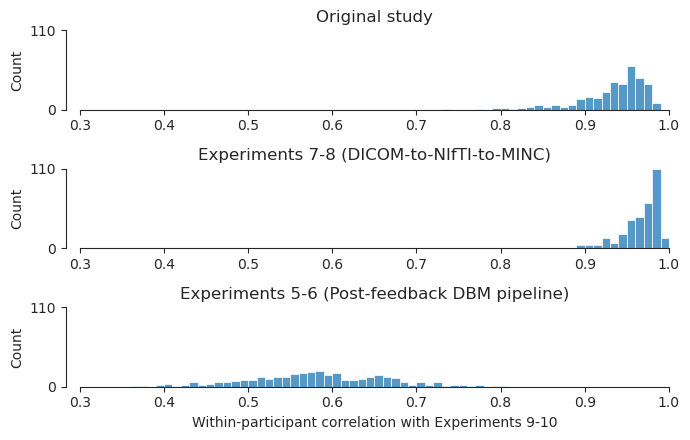

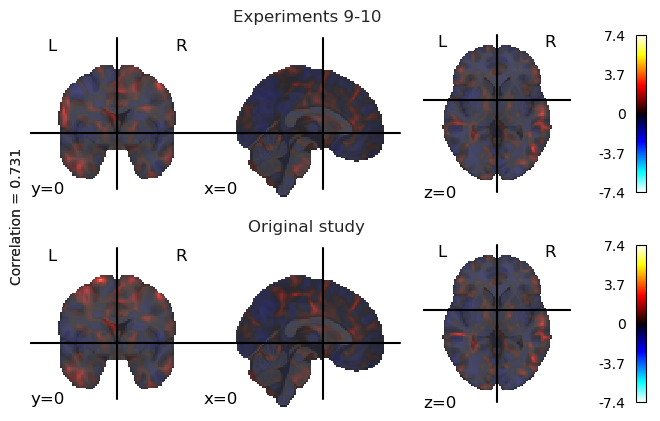

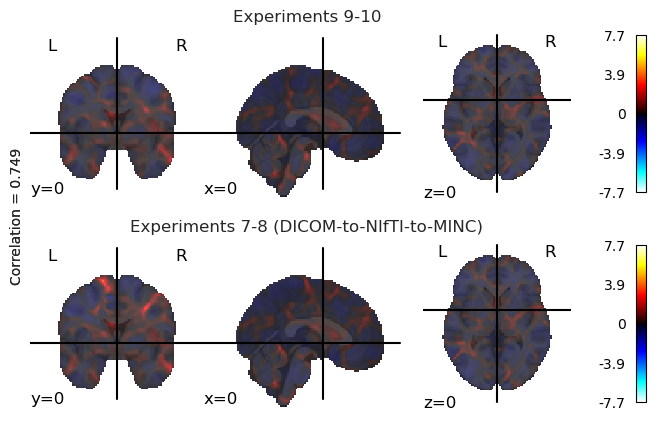

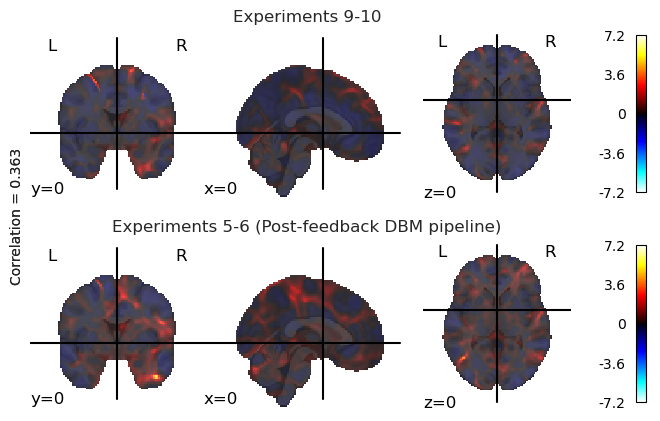

In [116]:
bin_min = 0.3
step = 0.01
bins = np.arange(bin_min, 1 + step, step)

tag_map = {
    '_460520092359662532_qc': 'Experiments 9-10',
    '_460520092359662532_from_nifti_qc': 'Experiments 7-8 (DICOM-to-NIfTI-to-MINC)',
    '_460520092359662532_old_pipeline_qc': 'Experiments 5-6 (Post-feedback DBM pipeline)',
    TAG_ORIGINAL_STUDY: 'Original study',
}

n_rows = len(TAG_PAIRS)
fig_corrs, axes_corrs = plt.subplots(
    nrows=n_rows, sharey='col', figsize=(7, 1.5*n_rows)
)

img_type = 'lowest' # 'lowest'/'highest'
cut_coords = (0,0,0)
alpha_dbm = 0.7
threshold_dbm = 0
pad_dbm = None

results_all = []
x_min = 1
x_max = -1
y_max = -1
for i_ax_corr, ((tag1, tag2), ax) in enumerate(zip(TAG_PAIRS, axes_corrs)):
    fpath_results = generate_filename(tag1, tag2)

    with fpath_results.open('rb') as file_results:
        results = pickle.load(file_results)

    results_all.append(results)
    corrs = results['corrs']

    assert bin_min < corrs.min(), print(f'min={corrs.min()}')
    print(f'{corrs.min():.3f}-{corrs.max():.3f}')
    print(f'Median:\t{corrs.median():.3f}')
    print(f'Mean:\t{corrs.mean():.3f}')

    x_min = np.floor(min(corrs.min(), x_min) / step) * step
    x_max = np.ceil(max(corrs.max(), x_max) / step) * step 

    sns.histplot(corrs, ax=ax, bins=bins)
    sns.despine(ax=ax, offset={'left': 10})
    # ax.set_title(f'{tag_map[tag1]} vs {tag_map[tag2]}')
    ax.set_title(f'{tag_map[tag2]}')

    y_max = max(max([h.get_height() for h in ax.patches]), y_max)

    if i_ax_corr == len(axes_corrs) - 1:
        ax.set_xlabel(f'Within-participant correlation with {tag_map[tag1]}')

    # plot DBM maps with lowest correlation
    fig_dbm, axes_dbm = plt.subplots(nrows=2, figsize=(8, 5))
    imgs_dbm = []
    vmax_dbm = -np.inf
    for i_ax_dbm in range(len(axes_dbm)):
        img_dbm = results[f'img{i_ax_dbm+1}_{img_type}']
        vmax_dbm = max(np.max(img_dbm.get_fdata()), vmax_dbm)
        imgs_dbm.append(img_dbm)
    for i_ax_dbm, (img_dbm, ax_dbm) in enumerate(zip(imgs_dbm, axes_dbm)):
        display_dbm = nilearn.plotting.plot_stat_map(
            img_dbm, axes=ax_dbm, threshold=threshold_dbm, 
            alpha=alpha_dbm, vmax=vmax_dbm, cut_coords=cut_coords)
        title = tag_map[results[f'tag{i_ax_dbm+1}']]
        if img_type == 'lowest':
            corr_index = 0
        else:
            corr_index = -1
        corr = results["corrs"].sort_values().iloc[corr_index]
        fig_dbm.text(
            0.1, 0.5, 
            f'Correlation = {corr:.3f}', 
            rotation='vertical',
            verticalalignment='center',
        )
        # if i_ax == 1:
        #     title = f'{title} (correlation: {results["corrs"].sort_values().iloc[0]:.3f})'
        display_dbm.axes['x'].ax.set_title(title, pad=pad_dbm)

        fig_dbm.savefig(f'fig_dbm{i_ax_corr+1}.svg', bbox_inches='tight')

    # break

print(f'x_min: {x_min}')
print(f'x_max: {x_max}')
print(f'y_max: {y_max}')
for ax in axes_corrs:
    ax.set_xlim(left=bin_min, right=x_max)
    ax.set_ylim(top=y_max)
    ax.set_yticks([0, y_max])

fig_corrs.tight_layout()

fig_corrs.savefig('fig_corrs.svg', bbox_inches='tight')
